In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
df = pd.read_csv('HR-Employee-Attrition.csv')
df.drop(['EmployeeCount', 'EmployeeNumber', 'StandardHours', 'Over18'], axis=1, inplace=True)

In [3]:
def unique_vals(col):

  if col.dtype == "object":

    print(f'{col.name}: {col.nunique()}')

df.apply(lambda col: unique_vals(col))





from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Create a label encoder object
le = LabelEncoder()

def label_encode(ser):

    if ser.dtype=="object" and ser.nunique() <= 2:
      print(ser.name)

      le.fit(ser)
      ser = le.transform(ser)

    return ser

df = df.apply(lambda col: label_encode(col))



# convert rest of categorical variable into dummy
df = pd.get_dummies(df, columns = ["BusinessTravel", "Department", "MaritalStatus"], drop_first = True)


target = df['Attrition'].copy()
df = df.drop(["Attrition"], axis = 1)
type(target)






# Since we have class imbalance (i.e. more employees with turnover=0 than turnover=1)
# let's use stratify=y to maintain the same ratio as in the training dataset when splitting the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df,
                                                    target,
                                                    test_size=0.25,
                                                    random_state=7,
                                                    stratify=target)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)



import category_encoders as ce

ce_target = ce.TargetEncoder(cols = ['EducationField', 'JobRole'])
X_train = ce_target.fit_transform(X_train, y_train)
X_test = ce_target.transform(X_test)




#Upsampling using SMOTE

from imblearn.over_sampling import SMOTE
from collections import Counter

smt = SMOTE()
X_sm, y_sm = smt.fit_resample(X_train, y_train)

print('Resampled dataset shape {}'.format(Counter(y_sm)))

Attrition: 2
BusinessTravel: 3
Department: 3
EducationField: 6
Gender: 2
JobRole: 9
MaritalStatus: 3
OverTime: 2
Attrition
Gender
OverTime
Number transactions X_train dataset:  (1102, 33)
Number transactions y_train dataset:  (1102,)
Number transactions X_test dataset:  (368, 33)
Number transactions y_test dataset:  (368,)
Resampled dataset shape Counter({0: 924, 1: 924})


In [4]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion = 'entropy')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred[:5]

array([0, 1, 0, 0, 1])

In [6]:
from sklearn.model_selection import cross_validate
depths = [1,2, 3,4,5,6,7,9,11,13,15]

for depth in depths:
    tree_clf = DecisionTreeClassifier(random_state=7, max_depth=depth)

    cv_acc_results = cross_validate(tree_clf, X_train, y_train, cv = 10, scoring = 'accuracy', return_train_score = True)

    print(f"K-Fold for depth:{depth} \
            Accuracy Mean: Train: {cv_acc_results['train_score'].mean().round(4)*100} \
            Validation: {cv_acc_results['test_score'].mean().round(4)*100}")

    print('***************')

K-Fold for depth:1             Accuracy Mean: Train: 83.85000000000001             Validation: 83.85000000000001
***************
K-Fold for depth:2             Accuracy Mean: Train: 85.87             Validation: 84.48
***************
K-Fold for depth:3             Accuracy Mean: Train: 86.91             Validation: 84.75
***************
K-Fold for depth:4             Accuracy Mean: Train: 88.92999999999999             Validation: 84.03
***************
K-Fold for depth:5             Accuracy Mean: Train: 90.72             Validation: 83.03
***************
K-Fold for depth:6             Accuracy Mean: Train: 92.52             Validation: 83.03
***************
K-Fold for depth:7             Accuracy Mean: Train: 94.16             Validation: 81.75
***************
K-Fold for depth:9             Accuracy Mean: Train: 96.98             Validation: 80.94
***************
K-Fold for depth:11             Accuracy Mean: Train: 98.77             Validation: 77.94
***************
K-Fold for depth:1

In [7]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state = 7, max_depth = 6)
tree_clf = tree_clf.fit(X_train, y_train)
pred = tree_clf.predict(X_test)


print(tree_clf.score(X_train, y_train))
print(tree_clf.score(X_test, y_test))

0.9228675136116152
0.8478260869565217


In [8]:
row_sample = X_train.sample(n=600, replace=True)
row_sample

,Age,DailyRate,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,MaritalStatus_Married,MaritalStatus_Single
887,42,458,26,5,0.127479,1,0,60,3,3,...,1,0,0,0,True,False,True,False,True,False
963,38,1009,2,2,0.151584,2,0,31,3,2,...,7,7,1,7,False,True,False,True,False,False
1287,42,1128,13,3,0.127479,2,1,95,4,2,...,0,0,0,0,False,True,True,False,True,False
374,28,304,9,4,0.151584,2,1,92,3,2,...,7,5,0,7,False,True,False,True,False,True
262,32,128,2,1,0.239544,4,1,84,2,2,...,6,2,0,4,False,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,58,286,2,4,0.151584,4,1,31,3,5,...,31,15,13,8,False,True,True,False,False,True
978,40,1202,2,1,0.127479,2,0,89,4,2,...,12,11,11,8,False,True,True,False,False,False
853,19,645,9,2,0.151584,3,1,54,3,1,...,1,1,0,0,False,True,True,False,False,True
1218,41,918,6,3,0.233869,4,1,35,3,3,...,10,8,8,7,False,True,False,True,False,True


In [9]:
#Sampling columns (We do not wish to repeat columns, hence replace=False in this case)
row_sample = row_sample.sample(n=5, replace=False, axis=1)
row_sample

,Education,YearsAtCompany,Age,PerformanceRating,EducationField
887,5,1,42,3,0.127479
963,2,7,38,3,0.151584
1287,3,0,42,3,0.127479
374,4,7,28,3,0.151584
262,1,6,32,3,0.239544
...,...,...,...,...,...
595,4,31,58,3,0.151584
978,1,12,40,4,0.127479
853,2,1,19,4,0.151584
1218,3,10,41,3,0.233869


In [10]:
from sklearn.ensemble import RandomForestClassifier

In [11]:
#n_estimators is the number of trees
rf_clf = RandomForestClassifier(random_state= 7, max_depth = 6, n_estimators= 100)

In [12]:
from sklearn.model_selection import cross_validate

In [13]:
cv_acc_results = cross_validate(rf_clf, X_train, y_train, cv=10, scoring='accuracy', return_train_score=True)

In [14]:
print(f"K-Fold Accuracy Mean: \n\
Train: {cv_acc_results['train_score'].mean()*100:.2f}\n\
Validation: {cv_acc_results['test_score'].mean()*100:.2f}")

K-Fold Accuracy Mean: 
Train: 89.77
Validation: 84.94


In [15]:
params = {
          'n_estimators' : [200,300,400],
          'max_depth' : [3,5,10],
          'max_features' : [8,9,10]
         }

from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator = RandomForestClassifier(),
                    param_grid = params,
                    scoring = 'accuracy',
                    cv = 3,
                    n_jobs=-1
                    )

grid.fit(X_train, y_train)

print("Best params: ", grid.best_params_)
print("Best score: ", grid.best_score_) # validation best score.


Best params:  {'max_depth': 10, 'max_features': 10, 'n_estimators': 200}
Best score:  0.862064625044426


In [18]:
clf2 = RandomForestClassifier(random_state=7, bootstrap=True, criterion='gini',
                             max_depth=10, max_features=8, n_estimators=200)

cv_acc_results = cross_validate(clf2, X_train, y_train, cv=10, scoring='accuracy', return_train_score=True)

print(f"K-Fold Accuracy Mean: \n Train: {cv_acc_results['train_score'].mean()*100:.3f} \n\
Validation: {cv_acc_results['test_score'].mean()*100:.2f}")

K-Fold Accuracy Mean: 
 Train: 98.830 
Validation: 85.93


In [21]:
from scipy.stats import uniform

params = {'ccp_alpha': uniform(loc=0, scale=0.4)}
#sample from uniform dist b/w 0 to 0.4

from sklearn.model_selection import RandomizedSearchCV

random = RandomizedSearchCV(estimator= RandomForestClassifier(random_state=7, bootstrap=False, criterion='gini',
                                                             max_depth=10, max_features=8, n_estimators=200),
                           
                           param_distributions = params,
                           scoring = 'accuracy',
                           cv = 3,
                           n_iter = 15,
                           n_jobs = 1
                           )

random.fit(X_train, y_train)

print("Best param: ", random.best_params_)
print("Best score: ", random.best_score_)

Best param:  {'ccp_alpha': np.float64(0.17162430338931906)}
Best score:  0.8384768787268491


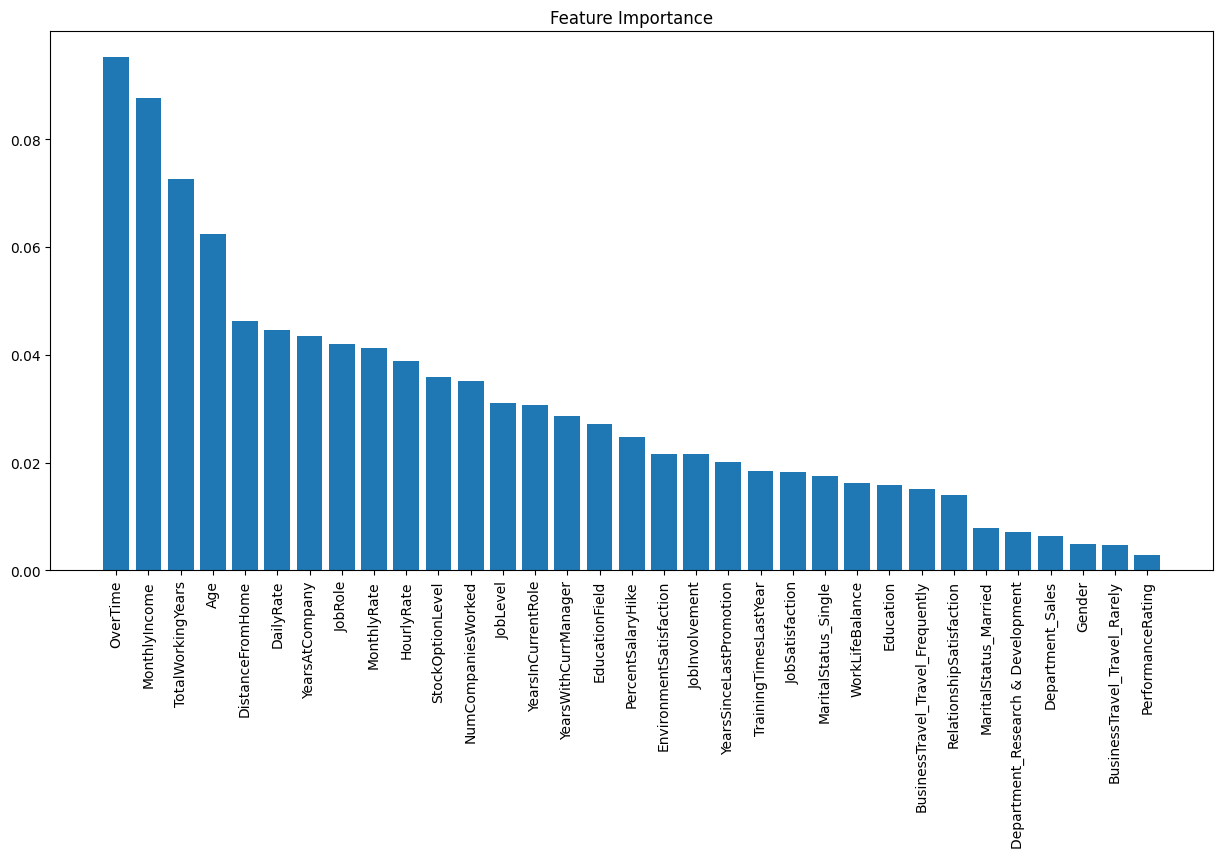

In [25]:
rf_clf.fit(X_train, y_train)
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [X_train.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances

plt.figure(figsize=(15, 7)) # Create plot
plt.title("Feature Importance") # Create plot title
plt.bar(range(X_train.shape[1]), importances[indices]) # Add bars
plt.xticks(range(X_train.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() # Show plot